In [9]:
# NEED TO USE predictors_simple kernel to be able to load the modles
import numpy as np
import pandas as pd
import tensorflow as tf # tested on version 2.2.0
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'
from matplotlib import pyplot as plt
from joblib import load
from scipy.stats import spearmanr
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns

import os

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction/scripts")
from Model import ADModel_act, ADModel_abund, ADModel_three_state_abund, ADModel_two_state_abund, ADModel_two_state, ADModel_three_state
from Data import DataReader, SplitData, FastTensorDataLoader, one_hot_encode

os.chdir("/Users/claireleblanc/Documents/tools_software/PADDLE")

import paddle
import os

os.chdir("/Users/claireleblanc/Documents/tools_software/adhunter")
from actpred.actpred.models import ActCNNSystem

# Set Numpy to display floats with 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction")

In [3]:
import matplotlib 
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

In [4]:
# READING IN FULL LENGTH VALIDATION SEQUENCES AND TILE DATA

data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/Unique_502_Gcn4_Seqs.csv", index_col=0)
val_seqs= data[data["heirarchical"] == 1]
train_seqs = data[data["heirarchical"] != 1]

tile_data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/pm_gcn4_sort2_pools_allchannels_wrangled.csv")

activity_dict = {}
for i in tile_data.index:
    activity_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"activity"]

abund_dict = {}
for i in tile_data.index:
    abund_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"abundance"]

used_tiles = []

def get_tile_activity(tile):
    used_tiles.append(tile)
    return activity_dict.get(tile)

def get_tile_abundance(tile):
    return abund_dict.get(tile)


# Break full length seqs into tiles, adding in the final tile
val_seqs["53_tiles"] = [[seq[i:i+53] for i in range(0,len(seq)-52)] + [seq[-53:]] for seq in val_seqs["Sequence"]]
val_seqs["53_tile_centers"] = [[i + 53/2 for i in range(0,len(seq)-52)] + [len(seq)-53/2] for seq in val_seqs["Sequence"]]
val_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in val_seqs["Sequence"]]
val_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in val_seqs["Sequence"]]
val_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]
val_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]


train_seqs["53_tiles"] = [[seq[i:i+53] for i in range(0,len(seq)-52)] + [seq[-53:]] for seq in train_seqs["Sequence"]]
train_seqs["53_tile_centers"] = [[i + 53/2 for i in range(0,len(seq)-52)] + [len(seq)-53/2] for seq in train_seqs["Sequence"]]
train_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in train_seqs["Sequence"]]
train_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in train_seqs["Sequence"]]
train_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]
train_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]

unused_tiles = list(set(tile_data["aa_seq"]).difference(set(used_tiles)))
other_tiles = pd.DataFrame(unused_tiles, columns=["aa_seq"])
other_tiles["activity"] = [get_tile_activity(s) for s in other_tiles["aa_seq"]]
other_tiles["abundance"] = [get_tile_abundance(s) for s in other_tiles["aa_seq"]]


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_50508/898701878.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["53_tiles"] = [[seq[i:i+53] for i in range(0,len(seq)-52)] + [seq[-53:]] for seq in val_seqs["Sequence"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_50508/898701878.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["53_tile_centers"] = [[i + 53/2 for i in range(0,len(seq)-52)] + [len(seq)-53/2] for seq in val_seqs["Sequence"]]
/var/folders/34/1p

In [5]:
# BIOPHYSICAL MODEL STUFF
import torch

size = (1,40,20)
positive = False
activity_fun = "Hill"
hill_value = 1
relu = False
kernel_size = 40
outchannel = 1
# model = "../Ablations/ablation_data/two-state_abundmodel_b10_e200_L0.0001_sMinMax_aHill_c1_k40_abundk15_noMax_ParaReLU_0.1PosKLoss_0.1PosWeightLoss_1actLoss_hSplit_hv1"

model = "model_data/two_state_abundmodel_b10_e200_L0.0001_sMinMax_aHill_c1_k40_ak20_ParaReLU_0.1PosKLoss_0.1PosWeightLoss_1actLoss_hSplit_hv1_seed5273682_weightInit"
two_state_biophysical_model = ADModel_two_state_abund(size,activity_fun, kernel_size, relu=False, abund_k=20)
two_state_biophysical_model.load_state_dict(torch.load(f"{model}.pth"))

two_state_biophysical_model.eval()

def run_biophysical_model(loaded_model,sequence):
    encoded_seq = one_hot_encode(sequence).reshape(1,1,40,20)
    seq_tensor = torch.from_numpy(encoded_seq).type(torch.FloatTensor)
    predictions = loaded_model(seq_tensor)
    predictions = predictions.detach().numpy().reshape(-1)
    return predictions

val_seqs["biophysics_gfp_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[1] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_gfp_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[1] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_gfp_pred_2"] = [run_biophysical_model(two_state_biophysical_model, tile)[1] for tile in other_tiles["aa_seq"]]

val_seqs["biophysics_mcherry_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[0] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_mcherry_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[0] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_mcherry_pred_2"] = [run_biophysical_model(two_state_biophysical_model, tile)[0] for tile in other_tiles["aa_seq"]]


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_50508/2932092469.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["biophysics_gfp_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[1] for tile in tiles] for tiles in val_seqs["40_tiles"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_50508/2932092469.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seqs["biophysics_gfp_pred_2"] = [[run_biophysical_model(two_state_biophysical_model, tile)[1] fo

In [6]:
# BIOPHYSICAL MODEL STUFF

size = (1,40,20)
positive = False
activity_fun = "Hill"
hill_value = 1
relu = False
kernel_size = 20
outchannel = 1
model = "model_data/three_state_abundmodel_b10_e200_L0.0001_sMinMax_aHill_c1_k20_ak20_ParaReLU_0.1PosKLoss_0.5PosWeightLoss_1actLoss_hSplit_hv1_seed830655019_weightInit"
three_state_biophysical_model = ADModel_three_state_abund(size,activity_fun, kernel_size, relu=False, abund_k=20)
three_state_biophysical_model.load_state_dict(torch.load(f"{model}.pth"))

three_state_biophysical_model.eval()

def run_biophysical_model(loaded_model,sequence):
    encoded_seq = one_hot_encode(sequence).reshape(1,1,40,20)
    seq_tensor = torch.from_numpy(encoded_seq).type(torch.FloatTensor)
    predictions = loaded_model(seq_tensor)
    predictions = predictions.detach().numpy().reshape(-1)
    return predictions

val_seqs["biophysics_gfp_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[1] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_gfp_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[1] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_gfp_pred_3"] = [run_biophysical_model(three_state_biophysical_model, tile)[1] for tile in other_tiles["aa_seq"]]

val_seqs["biophysics_mcherry_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[0] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_mcherry_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[0] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_mcherry_pred_3"] = [run_biophysical_model(three_state_biophysical_model, tile)[0] for tile in other_tiles["aa_seq"]]



/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_50508/2046028988.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_seqs["biophysics_gfp_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[1] for tile in tiles] for tiles in val_seqs["40_tiles"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_50508/2046028988.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seqs["biophysics_gfp_pred_3"] = [[run_biophysical_model(three_state_biophysical_model, tile)[1

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


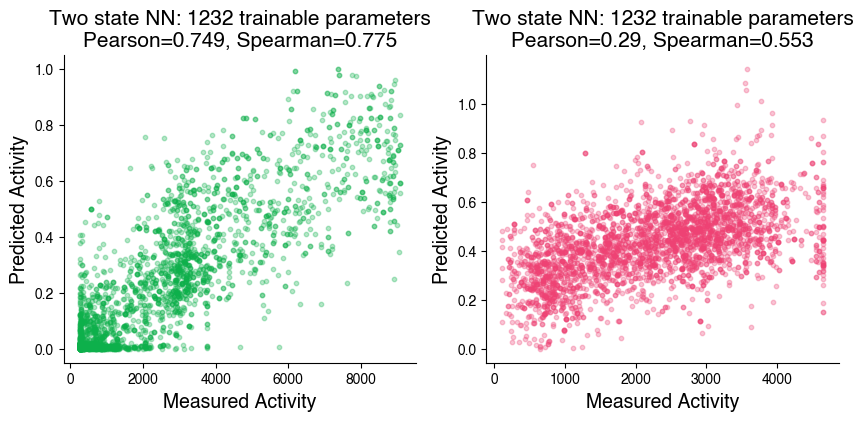

In [14]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

tiles = [i for ls in val_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in val_seqs["40_tiles_exp_activities"] for i in ls]
actual = actual + (list(other_tiles["activity"]))
pred = [i for ls in val_seqs["biophysics_gfp_pred_2"] for i in ls]
pred = pred + (list(other_tiles["biophysics_gfp_pred_2"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[0].scatter(actual, pred, color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] ** 2
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
axs[0].set_title(f'Two state NN: 1232 trainable parameters\nPearson={pearson:.3}, Spearman={spearman:.3}', fontsize=15)


tiles = [i for ls in val_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in val_seqs["40_tiles_exp_abundance"] for i in ls]
actual = actual + (list(other_tiles["abundance"]))
pred = [i for ls in val_seqs["biophysics_mcherry_pred_2"] for i in ls]
pred = pred + (list(other_tiles["biophysics_mcherry_pred_2"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[1].scatter(actual, pred, color='#EE4274', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] ** 2
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
axs[1].set_title(f'Two state NN: 1232 trainable parameters\nPearson={pearson:.3}, Spearman={spearman:.3}', fontsize=15)

sns.despine()
plt.savefig("figures/two_state_scatter_plots.pdf", format='pdf', bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


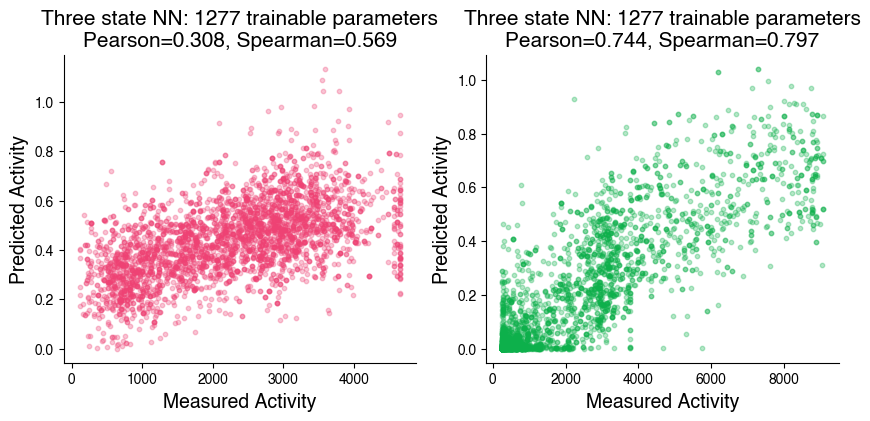

In [15]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

tiles = [i for ls in val_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in val_seqs["40_tiles_exp_abundance"] for i in ls]
actual = actual + (list(other_tiles["abundance"]))
pred = [i for ls in val_seqs["biophysics_mcherry_pred_3"] for i in ls]
pred = pred + (list(other_tiles["biophysics_mcherry_pred_3"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[0].scatter(actual, pred, color='#EE4274', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] ** 2
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
axs[0].set_title(f'Three state NN: 1277 trainable parameters\nPearson={pearson:.3}, Spearman={spearman:.3}', fontsize=15)

tiles = [i for ls in val_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in val_seqs["40_tiles_exp_activities"] for i in ls]
actual = actual + (list(other_tiles["activity"]))
pred = [i for ls in val_seqs["biophysics_gfp_pred_3"] for i in ls]
pred = pred + (list(other_tiles["biophysics_gfp_pred_3"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[1].scatter(actual, pred, color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] ** 2
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
axs[1].set_title(f'Three state NN: 1277 trainable parameters\nPearson={pearson:.3}, Spearman={spearman:.3}', fontsize=15)

sns.despine()
plt.savefig(f"figures/three_state_scatter_plots.pdf", format='pdf', bbox_inches='tight')

# Making convolution filter plots --> Two state

In [23]:
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Red, White, Blue
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

In [37]:
def make_row_plot_abund(fig, kernel_size, model, row, lim, height_ratios, num_rows, abund_kernel_size):

    model_conv1 = get_conv_weights(model, "conv1.weight").T
    model_linear1, model_xvals1 = get_linear_weights(model, "linear1.weight", kernel_size)

    model_conv2 = get_conv_weights(model, "conv2.weight").T
    model_linear2, model_xvals2 = get_linear_weights(model, "linear2.weight", abund_kernel_size)


    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1
    ratio1_abund = abund_kernel_size
    ratio2_abund = 40 - abund_kernel_size + 1

    gs1 = gridspec.GridSpec(2 + num_rows, 5, width_ratios=[ratio1, ratio2, 0.5, ratio1_abund, ratio2_abund], height_ratios=height_ratios, figure=fig)
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])
    ax3 = plt.subplot(gs1[row, 3])
    ax4 = plt.subplot(gs1[row, 4])


    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    # fig.colorbar(im)
    ax1.tick_params(axis='both', which='major', labelsize=6) 


    ax2.bar(model_xvals1, model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])


    im2 = ax3.imshow(model_conv2.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax3.set_yticks(range(len(model_conv2.index)), model_conv2.index)  # Label x-axis with column names
    ax3.set_xticks(np.arange(abund_kernel_size, step=2))
    for ytic in ax3.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax3.tick_params(axis='both', which='major', labelsize=6) 

    ax4.bar(model_xvals2, model_linear2, color="grey")
    ax4.spines["top"].set_visible(False)
    ax4.spines["left"].set_visible(False)
    ax4.spines["right"].set_visible(False)
    ax4.spines["bottom"].set_position('zero')
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])


    return ax1, ax2, ax5, ax6, im1, im2


In [25]:
def load_model(saved_model, model_type, kernel_size, hill_val, k_abund=0):
    # Data preparation 
    df = pd.read_csv(file)

    # Loading the data
    split_data = SplitData(data_reader,encoding_type="2D")
    X, y_abundance, y_activity, size = split_data.read_data(file, scale=scale)

    tensor_X = torch.from_numpy(X).type(torch.FloatTensor)
    tensor_y_abund = torch.from_numpy(np.array(y_abundance)).type(torch.FloatTensor)
    tensor_y_activity = torch.from_numpy(np.array(y_activity)).type(torch.FloatTensor)
    tensor_y = torch.stack((tensor_y_abund, tensor_y_activity)).transpose(0,1)

    data = FastTensorDataLoader(tensor_X, tensor_y, batch_size=len(tensor_X), shuffle=False)

    size = tuple(tensor_X.shape[1:4]) # Get second two dimensions (first dimension is # of samples)

    if k_abund > 0: 
        loaded_model = model_type(size,activity_fun,kernel_size,outchannel,relu,positive, hill_val, k_abund)
    else:
        loaded_model = model_type(size,activity_fun,kernel_size,outchannel,relu,positive, hill_val)
    loaded_model.load_state_dict(torch.load(f"{saved_model}.pth"))

    loaded_model.eval()

    # Looking at predictions for all
    pred_vals = loaded_model(tensor_X)

    k1s, closed = loaded_model.get_ks()
    k1_df = pd.DataFrame(k1s.detach().numpy(),columns=["K1"])
    closed_df = pd.DataFrame(closed.detach().numpy(),columns=["closed"])
    predictions = pd.DataFrame(pred_vals.detach().numpy().reshape(-1, 2),columns=["predicted_abundance","predicted_activity"])

    new_df = pd.concat([df, k1_df,closed_df,predictions],axis=1)
    # new_df = pd.concat([df, k1_df,k2_df,predictions],axis=1)

    sorted_df = new_df.sort_values(by = "activity")
    lowest_activity = sorted_df[0:round(0.1*len(sorted_df))]
    top_activity = sorted_df[round(0.9*len(sorted_df)):]
    return loaded_model, sorted_df

In [53]:
3 + num_rows

4

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


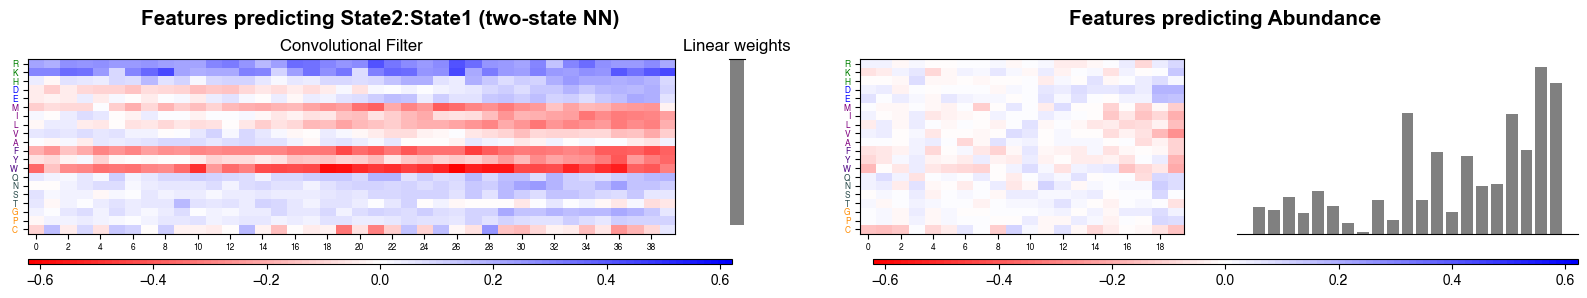

In [59]:
models = [two_state_biophysical_model]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())
    conv_weights += list(get_conv_weights(model, "conv2.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])
num_rows = 1

# Create a figure
fig = plt.figure(figsize=(20, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.3] + [3.3]*num_rows + [.1]*2

gs1 = gridspec.GridSpec(3 + num_rows, 2, width_ratios=[1,1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
ax1.set_title("Features predicting State2:State1 (two-state NN)", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax2 = plt.subplot(gs1[0,1])
ax2.set_title("Features predicting Abundance", fontdict=title_font)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.patch.set_visible(False)
ax2.axis('off')

ax1, ax2, ax3, ax4, im1, im2 = make_row_plot_abund(fig, 40, two_state_biophysical_model, 1, lim, height_ratios, num_rows+1, 20)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)
ax3.set_title("Convolutional Filter", fontsize=12)
ax4.set_title("Linear weights", fontsize=12)


gs_cb = gridspec.GridSpec(3 + num_rows, 2, width_ratios=[1,1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[2 + num_rows, 0])
cax2 = plt.subplot(gs_cb[2 + num_rows, 1])

# Add the colorbar
fig.colorbar(im1,cax=cax1, orientation='horizontal')
fig.colorbar(im2, cax=cax2, orientation='horizontal')

# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.pdf', dpi=1000, bbox_inches='tight')
plt.savefig('figures/two_state_parameters.pdf', dpi=1000, bbox_inches='tight')

# Making convolutional filter plots -> Three state

In [60]:
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Red, White, Blue
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

In [64]:
def make_row_plot_abund(fig, kernel_size, model, row, lim, height_ratios, num_rows, abund_kernel_size):

    model_conv1 = get_conv_weights(model, "conv1.weight").T
    model_linear1, model_xvals1 = get_linear_weights(model, "linear1.weight", kernel_size)

    model_conv2 = get_conv_weights(model, "conv2.weight").T
    model_linear2, model_xvals2 = get_linear_weights(model, "linear2.weight", kernel_size)

    model_conv3 = get_conv_weights(model, "conv3.weight").T
    model_linear3, model_xvals3 = get_linear_weights(model, "linear3.weight", abund_kernel_size)


    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1
    ratio1_abund = abund_kernel_size
    ratio2_abund = 40 - abund_kernel_size + 1

    gs1 = gridspec.GridSpec(2 + num_rows, 8, width_ratios=[ratio1, ratio2, 0.5, ratio1, ratio2, 0.5, ratio1_abund, ratio2_abund], height_ratios=height_ratios, figure=fig)
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])
    ax3 = plt.subplot(gs1[row, 3])
    ax4 = plt.subplot(gs1[row, 4])
    ax5 = plt.subplot(gs1[row, 6])
    ax6 = plt.subplot(gs1[row, 7])


    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    # fig.colorbar(im)
    ax1.tick_params(axis='both', which='major', labelsize=6) 


    ax2.bar(model_xvals1, model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])


    im2 = ax3.imshow(model_conv2.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax3.set_yticks(range(len(model_conv2.index)), model_conv2.index)  # Label x-axis with column names
    ax3.set_xticks(np.arange(kernel_size, step=2))
    for ytic in ax3.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax3.tick_params(axis='both', which='major', labelsize=6) 

    ax4.bar(model_xvals2, model_linear2, color="grey")
    ax4.spines["top"].set_visible(False)
    ax4.spines["left"].set_visible(False)
    ax4.spines["right"].set_visible(False)
    ax4.spines["bottom"].set_position('zero')
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])

    im3 = ax5.imshow(model_conv3.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax5.set_yticks(range(len(model_conv3.index)), model_conv3.index)  # Label x-axis with column names
    ax5.set_xticks(np.arange(abund_kernel_size, step=2))
    for ytic in ax5.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax5.tick_params(axis='both', which='major', labelsize=6) 

    ax6.bar(model_xvals3, model_linear3, color="grey")
    ax6.spines["top"].set_visible(False)
    ax6.spines["left"].set_visible(False)
    ax6.spines["right"].set_visible(False)
    ax6.spines["bottom"].set_position('zero')
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax6.set_xticklabels([])
    ax6.set_yticklabels([])

    return ax1, ax2, ax3, ax4, ax5, ax6, im1, im2, im3

In [62]:
file = "../Data/pm_gcn4_sort2_pools_allchannels_wrangled_no_max.csv"
positive = False
data_reader = DataReader()
scale = "MinMaxScaler"
activity_fun = "Hill"
relu = False
outchannel = 1

In [63]:
def load_model(saved_model, model_type, kernel_size, hill_val, k_abund=0):
    # Data preparation 
    df = pd.read_csv(file)

    # Loading the data
    split_data = SplitData(data_reader,encoding_type="2D")
    X, y_abundance, y_activity, size = split_data.read_data(file, scale=scale)

    tensor_X = torch.from_numpy(X).type(torch.FloatTensor)
    tensor_y_abund = torch.from_numpy(np.array(y_abundance)).type(torch.FloatTensor)
    tensor_y_activity = torch.from_numpy(np.array(y_activity)).type(torch.FloatTensor)
    tensor_y = torch.stack((tensor_y_abund, tensor_y_activity)).transpose(0,1)

    data = FastTensorDataLoader(tensor_X, tensor_y, batch_size=len(tensor_X), shuffle=False)

    size = tuple(tensor_X.shape[1:4]) # Get second two dimensions (first dimension is # of samples)

    if k_abund > 0: 
        loaded_model = model_type(size,activity_fun,kernel_size,outchannel,relu,positive, hill_val, k_abund)
    else:
        loaded_model = model_type(size,activity_fun,kernel_size,outchannel,relu,positive, hill_val)
    loaded_model.load_state_dict(torch.load(f"{saved_model}.pth"))

    loaded_model.eval()

    # Looking at predictions for all
    pred_vals = loaded_model(tensor_X)

    k1s, k2s, closed = loaded_model.get_ks()
    k1_df = pd.DataFrame(k1s.detach().numpy(),columns=["K1"])
    k2_df = pd.DataFrame(k2s.detach().numpy(),columns=["K2"])
    closed_df = pd.DataFrame(closed.detach().numpy(),columns=["closed"])
    predictions = pd.DataFrame(pred_vals.detach().numpy().reshape(-1, 2),columns=["predicted_abundance","predicted_activity"])

    new_df = pd.concat([df, k1_df,k2_df,closed_df,predictions],axis=1)
    # new_df = pd.concat([df, k1_df,k2_df,predictions],axis=1)

    sorted_df = new_df.sort_values(by = "activity")
    lowest_activity = sorted_df[0:round(0.1*len(sorted_df))]
    top_activity = sorted_df[round(0.9*len(sorted_df)):]
    return loaded_model, sorted_df

In [31]:
amino_acids = ["R","K","H","D","E","M","I","L","V","A","F","Y","W","Q","N","S","T","G","P","C"]

# Weights preparation
def get_conv_weights(model, layer): 
    model_state_dict = model.state_dict()
    width = model_state_dict[layer].shape[0] * model_state_dict[layer].shape[2]
    conv_weight = model_state_dict[layer].detach().numpy().reshape(width,20)
    conv_weights = pd.DataFrame(conv_weight,columns = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"])
    conv_weights = conv_weights[amino_acids]
    return conv_weights

def get_linear_weights(model, layer, kernel_size):
    linear_weights = (40 - kernel_size + 1)
    model_state_dict = model.state_dict()
    linear_weight = model_state_dict[layer].detach().numpy().reshape(linear_weights)
    x_vals = np.array(range(0,linear_weights))
    return linear_weight, x_vals


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


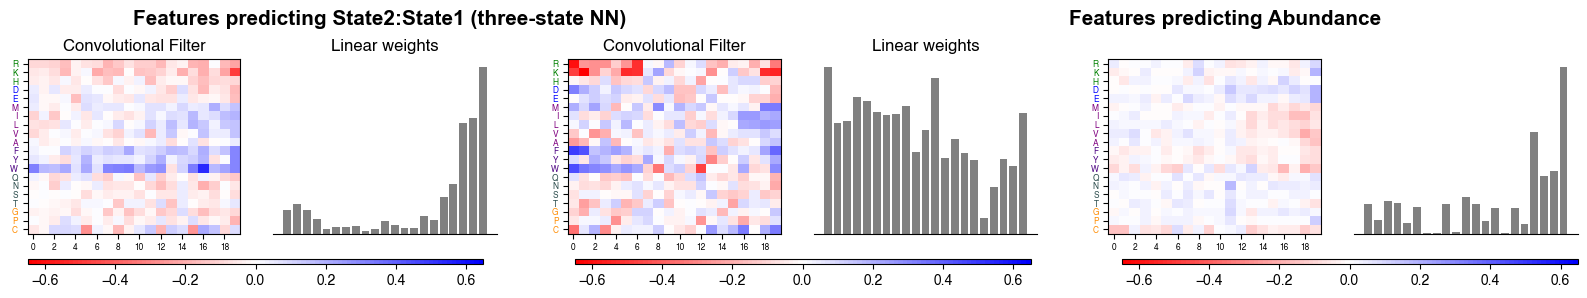

In [72]:
models = [three_state_biophysical_model]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())
    conv_weights += list(get_conv_weights(model, "conv2.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])
num_rows = 1

# Create a figure
fig = plt.figure(figsize=(20, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.3] + [3.3]*num_rows + [.1]*2

gs1 = gridspec.GridSpec(3 + num_rows, 2, width_ratios=[1,1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
ax1.set_title("Features predicting State2:State1 (three-state NN)", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax2 = plt.subplot(gs1[0,1])
ax2.set_title("Features predicting Abundance", fontdict=title_font)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.patch.set_visible(False)
ax2.axis('off')

ax1, ax2, ax3, ax4, ax5, ax6, im1, im2, im3 = make_row_plot_abund(fig, 20, three_state_biophysical_model, 1, lim, height_ratios, num_rows+1, 20)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)
ax3.set_title("Convolutional Filter", fontsize=12)
ax4.set_title("Linear weights", fontsize=12)


gs_cb = gridspec.GridSpec(3 + num_rows, 3, width_ratios=[1,1,1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[2 + num_rows,0])
cax2 = plt.subplot(gs_cb[2 + num_rows,1])
cax3 = plt.subplot(gs_cb[2 + num_rows,2])

# Add the colorbar
fig.colorbar(im1,cax=cax1, orientation='horizontal')
fig.colorbar(im2, cax=cax2, orientation='horizontal')
fig.colorbar(im3, cax=cax3, orientation='horizontal')

# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.pdf', dpi=1000, bbox_inches='tight')
plt.savefig('figures/three_state_parameters.pdf', dpi=1000, bbox_inches='tight')

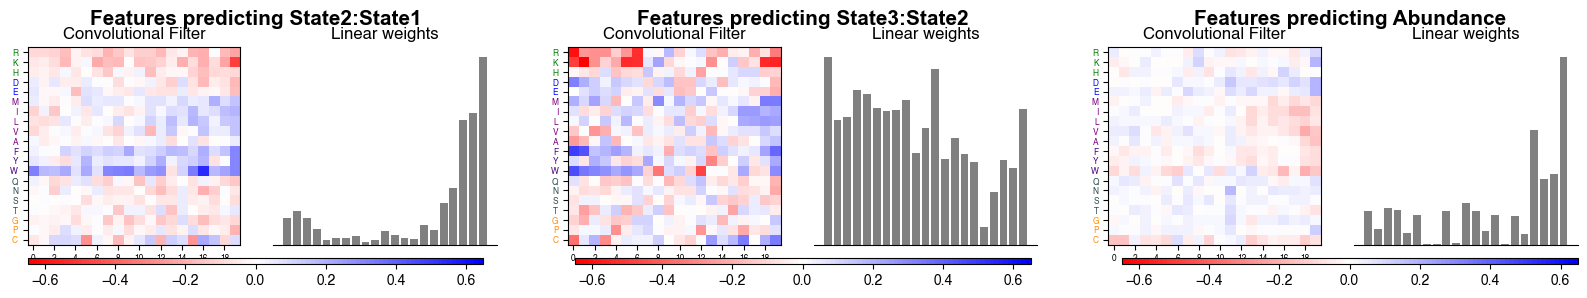

In [34]:


num_rows = 1

models = [three_state_biophysical_model]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())
    conv_weights += list(get_conv_weights(model, "conv2.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(20, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}


height_ratios = [.01] + [3.3]*num_rows + [.1]

gs1 = gridspec.GridSpec(2 + num_rows, 3, width_ratios=[1,1,1], height_ratios=height_ratios, figure=fig)
ax1 = plt.subplot(gs1[0,0])
ax1.set_title("Features predicting State2:State1", fontdict=title_font)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.patch.set_visible(False)
ax1.axis('off')

ax2 = plt.subplot(gs1[0,1])
ax2.set_title("Features predicting State3:State2", fontdict=title_font)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.patch.set_visible(False)
ax2.axis('off')

ax3 = plt.subplot(gs1[0,2])
ax3.set_title("Features predicting Abundance", fontdict=title_font)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.patch.set_visible(False)
ax3.axis('off')

ax1, ax2, ax3, ax4, ax5, ax6, im1, im2, im3 = make_row_plot_abund(fig, 20, three_state_biophysical_model, 1, lim, height_ratios, num_rows, 20)

ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)
ax3.set_title("Convolutional Filter", fontsize=12)
ax4.set_title("Linear weights", fontsize=12)
ax5.set_title("Convolutional Filter", fontsize=12)
ax6.set_title("Linear weights", fontsize=12)

# make_row_plot_abund(fig, 10, model_10, 2, lim, height_ratios, num_rows, abundK)

gs_cb = gridspec.GridSpec(2 + num_rows, 3, width_ratios=[1,1,1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[1 + num_rows,0])
cax2 = plt.subplot(gs_cb[1 + num_rows,1])
cax3 = plt.subplot(gs_cb[1 + num_rows,2])

# Add the colorbar
fig.colorbar(im1,cax=cax1, orientation='horizontal')
fig.colorbar(im2, cax=cax2, orientation='horizontal')
fig.colorbar(im3, cax=cax3, orientation='horizontal')

# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.pdf', dpi=1000, bbox_inches='tight')
# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.png', dpi=1000, bbox_inches='tight')